# NBA Data Exploration
## Bryce Mann

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot
from datetime import datetime
import time

In [2]:
from nba_api.stats.endpoints import leaguedashteamstats as ts
from nba_api.stats.library.parameters import PerModeDetailed, SeasonAll, MeasureTypeDetailed

per100 = PerModeDetailed.per_100_possessions
all_seasons = SeasonAll.all
adv = MeasureTypeDetailed.advanced

In [3]:
def make_season_list(year1, year2):
    seasons = []
    for n in range(year1, year2):
        season = str(n) + '-' + str(n+1)[2:]
        seasons.append(season)
    return seasons

In [4]:
def pull_dfs(clss, y1, y2, **kwargs):
    seasons = make_season_list(y1, y2)
    for season in seasons:
        data = clss(season=season, **kwargs)
        temp_df = data.get_data_frames()[0]
        temp_df['Season'] = season
        pd.to_pickle(temp_df, 'teams_adv/' + str(season) + '.pkl')

# pull_dfs(ts.LeagueDashTeamStats, 1996, 2019,
#          measure_type_detailed_defense=adv)

In [5]:
test = pd.read_pickle('teams_adv/2018-19.pkl')
test.columns

Index(['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE', 'PIE',
       'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK',
       'OFF_RATING_RANK', 'DEF_RATING_RANK', 'NET_RATING_RANK', 'AST_PCT_RANK',
       'AST_TO_RANK', 'AST_RATIO_RANK', 'OREB_PCT_RANK', 'DREB_PCT_RANK',
       'REB_PCT_RANK', 'TM_TOV_PCT_RANK', 'EFG_PCT_RANK', 'TS_PCT_RANK',
       'PACE_RANK', 'PIE_RANK', 'CFID', 'CFPARAMS', 'Season'],
      dtype='object')

### Is offense getting more important?
**Many basketball analysts today say that offense is becoming more important to team success and that the NBA will continue to trend that way. Is it true?**

To try an answer this question I look at advanced team stats from the first year they were collected (1996) to this past season. The two in particular I look at are Offensive and Defensive efficency, or the amount of points a team scores and gives up, respectively, per 100 possessions; this is probably the most baseline measure of a team these days, in terms of advanced stats. To see what I was working with I first normalized the efficiencies of each season, then plotted each teams numbers (offensive on the x-axis, defensive on the inverted y-axis; the teams good on both sides of the ball are on the top right), with the dot size indicating where they ended in the league standings that year. The larger the dot, the better the team.

/home/bryce/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/bryce/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/bryce/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

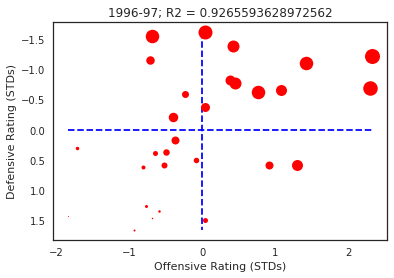

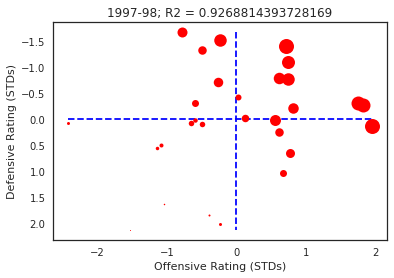

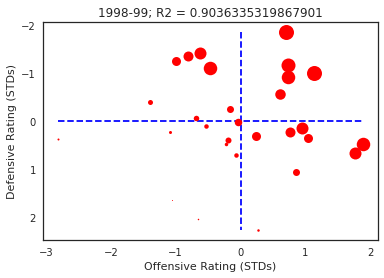

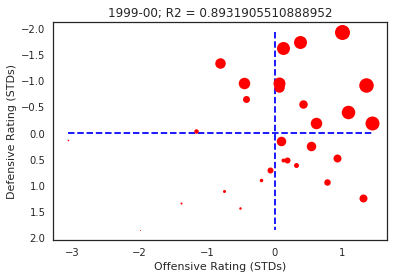

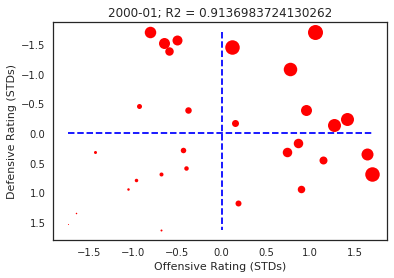

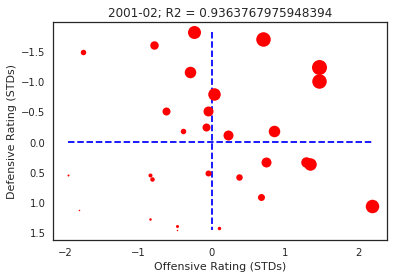

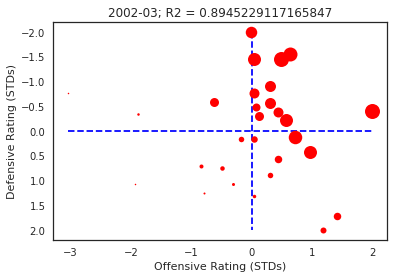

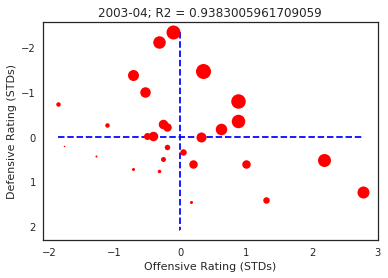

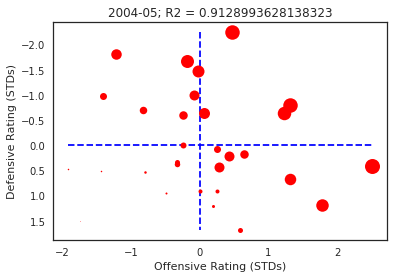

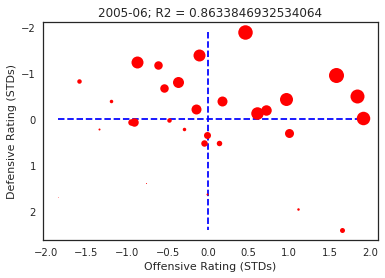

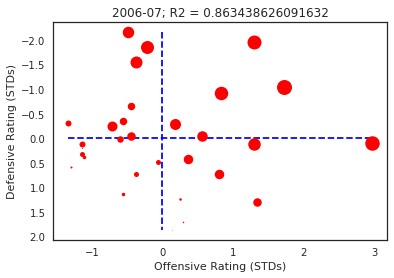

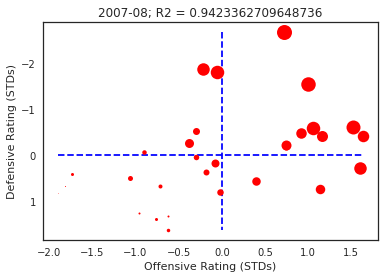

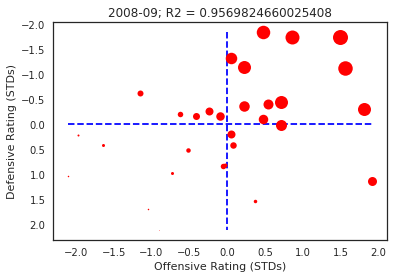

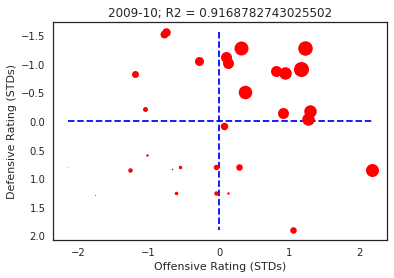

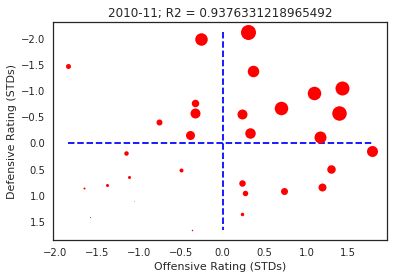

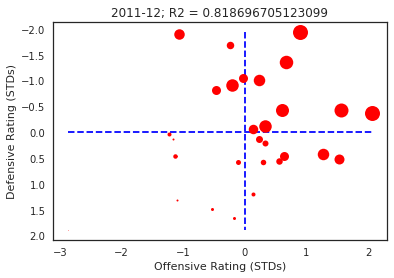

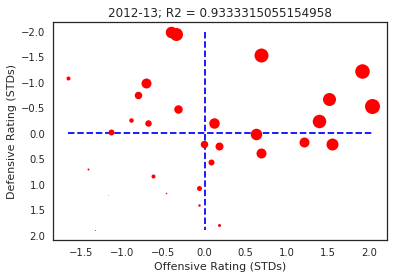

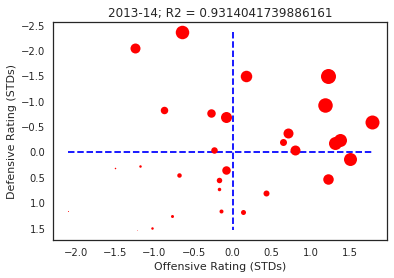

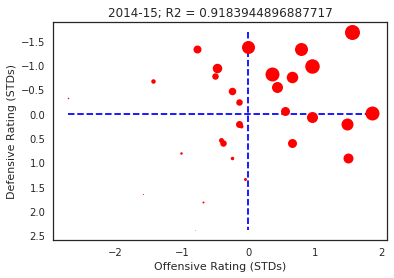

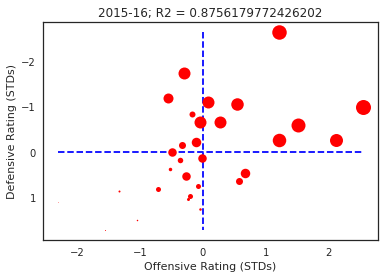

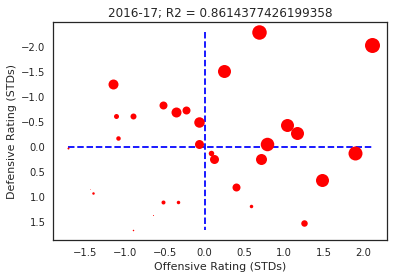

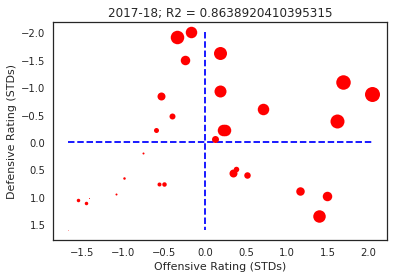

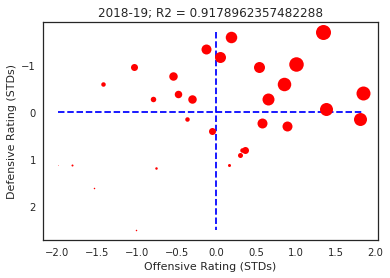

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize

seasons = make_season_list(1996, 2019)
d = dict()

for season in seasons:
    
    df = pd.read_pickle('teams_adv/' + season + '.pkl')
    x = df['OFF_RATING'].values
    xnorm = (x - np.mean(x))/np.std(x)
    y = df['DEF_RATING'].values
    ynorm = (y - np.mean(y))/np.std(y)
    avgx = np.mean(x)
    avgy = np.mean(y)
    
    linreg = LinearRegression(normalize=True)
    X = df[['OFF_RATING', 'DEF_RATING']]
    Y = df['W_RANK']
    linreg.fit(X,Y)
    r2 = linreg.score(X, Y)
    d[season] = linreg.coef_
    
    plt.figure()
    plt.title(season + '; R2 = ' + str(r2))
    plt.gca().invert_yaxis()
    plt.xlabel('Offensive Rating (STDs)')
    plt.ylabel('Defensive Rating (STDs)')
    plt.plot([0, 0], [min(ynorm), max(ynorm)], 'b--')
    plt.plot([min(xnorm), max(xnorm)], [0, 0], 'b--')
    for i, val in enumerate(xnorm):
        size = (31 - df['W_RANK'].values[i])
        plt.plot(xnorm[i],ynorm[i],'r.', markersize=size)

**Results**

Once I plotted efficiencies and standing rank I wanted to see if the relative importance of either side of the ball has been increasing or decreasing as the years have gone by. To look at this I plotted the ratio of the coefficients corresponding the each efficiency against the year that ratio was computed for. As the ratio goes farther from 0, the more dependent on offensive production teams are to win. Looking at the straight scatter plot doesn't jump out, so I run regression on it below.

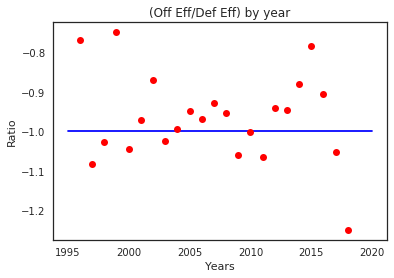

In [7]:
plt.figure()
plt.plot([1995, 2020], [-1, -1], 'b-')
plt.title('(Off Eff/Def Eff) by year')
plt.xlabel('Years')
plt.ylabel('Ratio')

ratios = []

for season in seasons:
    ratio = d[season][0]/d[season][1]
    ratios.append(ratio)
    plt.plot(int(season[0:4]),ratio, 'ro')

**Correlation Matrix**

At first glance it doesn't seem like the ratio can be very well explained by the season number or season squared.

In [8]:
df = pd.DataFrame(
    {'season': range(1996,2019),
     'season2': [x**2 for x in range(1996,2019)],
     'ratio': ratios,
     })
df.corr()

,season,season2,ratio
season,1.000000,0.999999,-0.217065
season2,0.999999,1.000000,-0.217134
ratio,-0.217065,-0.217134,1.000000


In [9]:
x = df['season'].values.reshape(-1,1)
y = df['ratio'].values.reshape(-1,1)
linreg = LinearRegression()
linreg.fit(x,y)
r1 = linreg.score(x,y)

p = [linreg.coef_[0][0], linreg.intercept_[0]]

x1 = np.linspace(1996,2018,100)
y1 = np.polyval(p, x1)

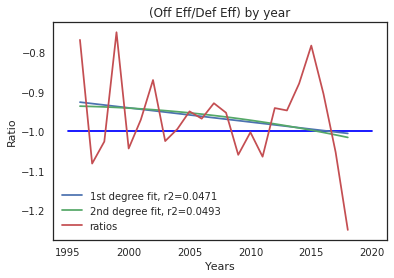

In [10]:
linreg = LinearRegression()
x2 = df[['season', 'season2']].values
y = df['ratio'].values.reshape(-1,1)
linreg.fit(x2,y)
r2 = linreg.score(x2,y)

p = [linreg.coef_[0][1], linreg.coef_[0][0], linreg.intercept_[0]]

x2 = np.linspace(1996,2018,100)
y2 = np.polyval(p, x2)

plt.figure()
plt.plot([1995, 2020], [-1, -1], 'b-')
plt.title('(Off Eff/Def Eff) by year')
plt.xlabel('Years')
plt.ylabel('Ratio')

plt.plot(x1, y1, label='1st degree fit, r2=' + str(np.around(r1,4)))
plt.plot(x2, y2, label='2nd degree fit, r2=' + str(np.around(r2,4)))

plt.plot(df['season'].values, ratios, label='ratios')

plt.legend()
plt.show()

## Conclusion
There is a definite negative trend as the years have gone by, but there is a lot of noise in the data as well, so it looks most likely like it is due to randomness.

# Who is (in)consistent?
**Here I set out to see who are the most consistent and inconsistent performers in the NBA**

The next 2 cells pull data.

In [11]:
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
tid_list = []
abv_list = []

for i in range(len(nba_teams)):
    tup1 = nba_teams[i]['id']
    tup2 = nba_teams[i]['abbreviation']
    tid_list.append(tup1)
    abv_list.append(tup2)

In [12]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import PlayerOrTeamAbbreviation
from nba_api.stats.library.parameters import Season
import requests_cache
from datetime import datetime
from dateutil.parser import parse

#requests_cache.install_cache('demo_cache')

def date_from(df, y=2018, m=10, d=16):
    idx = []
    while len(idx)==0:
        date = str(y) + '-' + str(m) + '-' + str(d)
        idx = df.loc[df['GAME_DATE']==date].index
        d += 1
    return df.truncate(after=max(idx))

# for tid in tid_list:
#     gamefinder = leaguegamefinder.LeagueGameFinder(
#                  player_or_team_abbreviation=PlayerOrTeamAbbreviation.player,
#                  team_id_nullable=tid)

#     games = gamefinder.get_data_frames()[0]
#     games = games[games['SEASON_ID']=='22018']
#     games = date_from(games)
    
    
#     pd.to_pickle(games, 'games/' + str(tid) + '.pkl')

In [13]:
test = pd.read_pickle('games/' + str(tid_list[6]) + '.pkl')
test

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
108,22018,1627750,Jamal Murray,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,0.500,2.0,6.0,8.0,7.0,0.0,1.0,2.0,0.0,16.0
109,22018,1628420,Monte Morris,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,NaN,0.0,2.0,2.0,3.0,1.0,0.0,0.0,1.0,-10.0
110,22018,1628470,Torrey Craig,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,0.500,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,-10.0
111,22018,203486,Mason Plumlee,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,NaN,2.0,4.0,6.0,2.0,0.0,1.0,0.0,0.0,-15.0
112,22018,200794,Paul Millsap,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,0.500,1.0,7.0,8.0,3.0,0.0,0.0,2.0,2.0,17.0
113,22018,203115,Will Barton,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,0.500,1.0,8.0,9.0,4.0,1.0,1.0,1.0,1.0,9.0
114,22018,203914,Gary Harris,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,0.800,2.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,6.0
115,22018,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,1.000,3.0,11.0,14.0,2.0,3.0,0.0,4.0,4.0,16.0
116,22018,1627736,Malik Beasley,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,...,NaN,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-9.0
117,22018,203914,Gary Harris,1610612743,DEN,Denver Nuggets,0021801217,2019-04-09,DEN @ UTA,L,...,NaN,0.0,0.0,0.0,2.0,1.0,0.0,0.0,5.0,-12.0


**Functions used to compute everything I need**

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def get_chunk(df, i, column='PTS'):
    
    length = len(df)
    
    if i < 11:
        idx1 = 0
        idx2 = i+10
    elif i > length-10:
        idx1 = i-10
        idx2 = length
    else:
        idx1 = i - 10
        idx2 = i + 10
    
    return df.iloc[idx1:idx2]

def calc_mse(chunk, column=''):
    
    x = np.array(chunk.index).reshape(-1,1)
    
    avg = np.mean(chunk[column].values)
    std = np.std(chunk[column].values)
    y = np.array(chunk[column]).reshape(-1,1)
    
    linreg = LinearRegression()
    linreg.fit(x,y)
    y_pred = linreg.predict(x)
    
    mse = mean_squared_error(y, y_pred)
    
    return mse

def calc_min(d_min, consistency, pid):

    if len(d_min.columns) < 3:
        d_min[pid] = consistency[pid].values
        return d_min
    
    high_mse = np.mean(consistency[pid].dropna())
    high_pid = pid
    
    for col in d_min:
        temp_mse = np.mean(d_min[col].dropna())
        if high_mse < temp_mse:
            high_mse = temp_mse
            high_pid = col
        
    if high_pid != pid:
        d_min[pid] = consistency[pid].values
        idc = d_min.pop(high_pid)
        return d_min
    else:
        return d_min
    

def calc_max(d_max, consistency, pid):
    
    if len(d_max.columns) < 3:
        d_max[pid] = consistency[pid].values
        return d_max
    
    low_mse = np.mean(consistency[pid].dropna())
    low_pid = pid
    
    for col in d_max:
        temp_mse = np.mean(d_max[col].dropna())
        if low_mse > temp_mse:
            low_mse = temp_mse
            low_pid = col
        
    if low_pid != pid:
        d_max[pid] = consistency[pid].values
        idc = d_max.pop(low_pid)
        return d_max
    else:
        return d_max    

def loop_games(df, d_min, d_max, pid, column='PTS'):
    
    df2 = df.reset_index()
    
    if len(df2) > 41:
        
        nan_list = 83*[np.nan]
        consistency = pd.DataFrame(data=nan_list, columns=[pid])
        
        for idx, row in df2.iterrows():
                       
            chunk = get_chunk(df2, idx, column=column)
            mse = calc_mse(chunk, column=column)
            consistency[pid].iloc[idx] = mse
            
        new_dmin = calc_min(d_min, consistency, pid)
        new_dmax = calc_max(d_max, consistency, pid)
        
        return new_dmin, new_dmax
    return d_min, d_max

def loop_teams(tid_list, column='PTS', threshold=15):
    
    nan_list = 83*[np.nan]
    
    d_min = pd.DataFrame()
    d_max = pd.DataFrame()
    
    for tid in tid_list:
        team_df = pd.read_pickle('games/' + str(tid) + '.pkl')
        grouped = team_df.groupby('PLAYER_ID')
        for name, group in grouped:
            player_df = grouped.get_group(name)
            if np.mean(player_df[column].values) >= threshold:
                d_min, d_max= loop_games(player_df, d_min, d_max,
                                         name, column=column)
            else:
                pass
    return d_min, d_max

dmin, dmax = loop_teams(tid_list, column='FG_PCT', threshold=.4)

**Methodology**
With the function I wrote above, I can enter a box score statistic and a lower bound threshold, where no one who averaged less than that value for a whole season can be considered. From there it goes through every game they played during the season; for each game it runs linear regression on the 20 games around it. From there it uses that model and the actual point totals to compute the mean squared error of each game. As of right now I then average the mean squared errors, and save the players with the 3 largest and smallest averages.

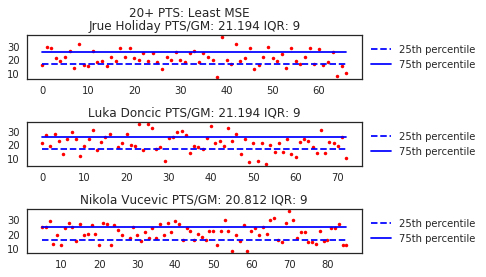

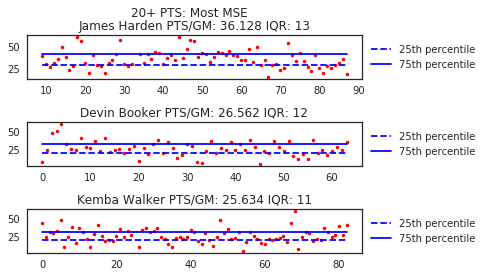

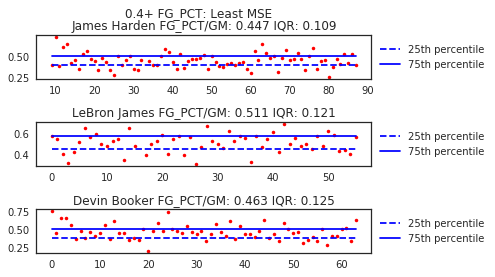

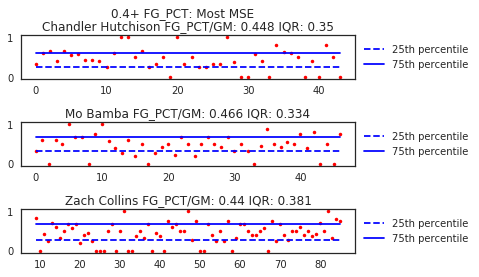

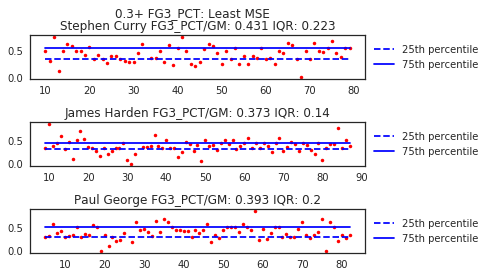

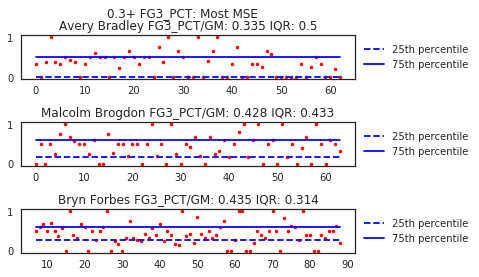

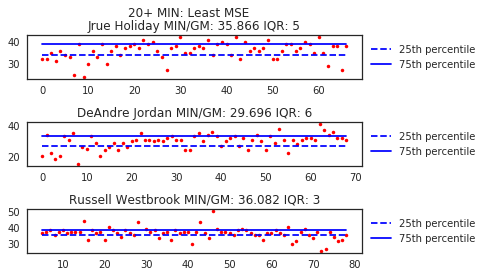

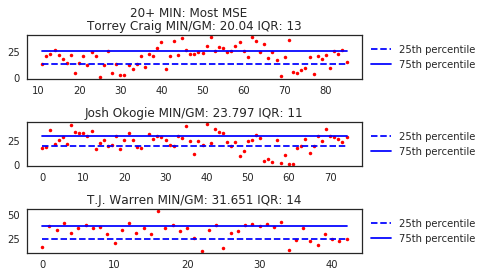

In [16]:
from nba_api.stats.static import players
from matplotlib.pyplot import subplots_adjust
from thinkstats2 import Cdf

columns = ['PTS', 'FG_PCT', 'FG3_PCT', 'MIN']
thresholds = [20, .4, .3, 20]

for i in range(len(columns)):
    dmin, dmax = loop_teams(tid_list, column=columns[i],
                            threshold=thresholds[i])
    fig = plt.figure()
    fig.suptitle(str(thresholds[i]) + '+ ' + columns[i] +
                 ': Least MSE')
    plt.xlabel('Games')
    plt.ylabel('Total ' + columns[i])
    n = 1
    for col in dmin:
        ax = plt.subplot("31"+str(n))
        n += 1
        
        gamefinder = leaguegamefinder.LeagueGameFinder(
        player_or_team_abbreviation=PlayerOrTeamAbbreviation.player,
        player_id_nullable=int(col))
        games = gamefinder.get_data_frames()[0]
        games = games[games['SEASON_ID']=='22018']
        games = date_from(games)
        cdf = Cdf(games[columns[i]].values)
        [lqr, uqr] = cdf.Percentile(25), cdf.Percentile(75) 

        ax.plot(games.index, games[columns[i]].values, 'r.')
        
        ax.plot([min(games.index), max(games.index)], [lqr, lqr],
                'b--', label='25th percentile') 
        ax.plot([min(games.index), max(games.index)], [uqr, uqr],
                'b-', label='75th percentile')
        
        p = players.find_player_by_id(int(col))
        name = p['full_name']
        ax.set_title(name + ' ' + columns[i] + '/GM: ' + 
                     str(np.around(np.mean(games[columns[i]]), 3)) +
                     ' IQR: ' + str(np.around(uqr-lqr, 3)))
        ax.legend(bbox_to_anchor=(1, 1))
    
    plt.subplots_adjust(hspace=1)
    plt.show()
    
    fig = plt.figure()
    fig.suptitle(str(thresholds[i]) + '+ ' + columns[i] +
                 ': Most MSE')
    plt.xlabel('Games')
    plt.ylabel('Total ' + columns[i])
    n = 1
    for col in dmax:
        ax = plt.subplot("31"+str(n))
        n += 1
        
        gamefinder = leaguegamefinder.LeagueGameFinder(
        player_or_team_abbreviation=PlayerOrTeamAbbreviation.player,
        player_id_nullable=int(col))
        games = gamefinder.get_data_frames()[0]
        games = games[games['SEASON_ID']=='22018']
        games = date_from(games)
        cdf = Cdf(games[columns[i]].values)
        [lqr, uqr] = cdf.Percentile(25), cdf.Percentile(75)

        ax.plot(games.index, games[columns[i]].values, 'r.')
        
        ax.plot([min(games.index), max(games.index)], [lqr, lqr],
                'b--', label='25th percentile') 
        ax.plot([min(games.index), max(games.index)], [uqr, uqr],
                'b-', label='75th percentile')
        
        p = players.find_player_by_id(int(col))
        name = p['full_name']
        ax.set_title(name + ' ' + columns[i] + '/GM: ' + 
                     str(np.around(np.mean(games[columns[i]]), 3)) +
                     ' IQR: ' + str(np.around(uqr-lqr, 3)))
        ax.legend(bbox_to_anchor=(1, 1))
        
    plt.subplots_adjust(hspace=1)
    plt.show()        

**Results**

I just got this working, I will take a few minutes today to mess around with columns and threshold values to see if anything really interesting comes up. Each plot has the box score values from every game the player played in this past season, along with the IQR of all of those values and their per game averages.

# Positions, are they useless?
**Using a KNeighbors model, I will try to see if position designations are becoming less meaningful as time goes on**

This has been the most difficult question I've been working on, its still in progress but I am close enough to get there soon. Basically I want to grab every season back to a certain point, and get a dataframe that has every player that played that season as their own row. Columns will start out being physical measurements and per game stats. The plan is to fit the model to each year, and see if the same models are becoming more or less accurate as versitility is taken as a premium now in the NBA.